# Trabajo practico integrador: Parte 2
## [Crimenes ocurridos en la ciudad de Chicago (2024)](https://data.cityofchicago.org/Public-Safety/Crimes-in-Chicago/ijzp-q8t2)

### Grupo: 9
### Alumno: Maxim Dorogov

## Objetivo
El objetivo de este trabajo es realizar una preparacion de datos (limpieza, correccion, feature engineering y split), para resolver un problema de clasificacion sobre un dataset de los crimenes ocurridos en la ciudad de Chicago en el año 2024. Para ello vamos a partir del dataset utilizado en la parte 1 del trabajo practico del cual se eliminaron columnas que no eran relevantes para el analisis.

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('Crimes_-_2024_20250701_filtered.csv')
df.head()

,Date,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Latitude,Longitude
0,12/31/2024 11:58:00 PM,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,332,3,5,43.0,14,1186817.0,1860189.0,41.771470,-87.590742
1,12/31/2024 11:56:00 PM,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,223,2,3,38.0,26,1179661.0,1873623.0,41.808501,-87.616563
2,12/31/2024 11:55:00 PM,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,834,8,18,70.0,04B,1145740.0,1853048.0,41.752749,-87.741498
3,12/31/2024 11:53:00 PM,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,321,3,20,42.0,14,1184362.0,1861188.0,41.774269,-87.599710
4,12/31/2024 11:50:00 PM,0460,BATTERY,SIMPLE,SIDEWALK,False,False,2531,25,29,25.0,08B,1137458.0,1907694.0,41.902858,-87.770537


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258378 entries, 0 to 258377
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  258378 non-null  object 
 1   IUCR                  258378 non-null  object 
 2   Primary Type          258378 non-null  object 
 3   Description           258378 non-null  object 
 4   Location Description  257325 non-null  object 
 5   Arrest                258378 non-null  bool   
 6   Domestic              258378 non-null  bool   
 7   Beat                  258378 non-null  int64  
 8   District              258378 non-null  int64  
 9   Ward                  258378 non-null  int64  
 10  Community Area        258376 non-null  float64
 11  FBI Code              258378 non-null  object 
 12  X Coordinate          257370 non-null  float64
 13  Y Coordinate          257370 non-null  float64
 14  Latitude              257370 non-null  float64
 15  

### Tratamiento de datos faltantes y duplicados


In [6]:
# Identifico columnas con faltantes y sus respectivas cantidades
missing_columns = df.isnull().sum()
missing_columns[missing_columns > 0]

Location Description    1053
Community Area             2
X Coordinate            1008
Y Coordinate            1008
Latitude                1008
Longitude               1008
dtype: int64

Algo que se discutio brevemente en el trabajo anterior fue la posible correlacion entre X Coordinate, Y Coordinate con Latitude, Longitude. Ya que en la documentacion se
indica que las coordenadas X e Y son las coordenadas de la ubicacion del crimen en un sistema de coordenadas particular, mientras que Latitude y Longitude son las coordenadas geograficas. Por lo tanto, se puede intuir que X Coordinate y Y Coordinate son equivalentes a Latitude y Longitude. Para confirmar esto calculamos y graficamos la correlacion entre las columnas X Coordinate, Y Coordinate y Latitude, Longitude. 

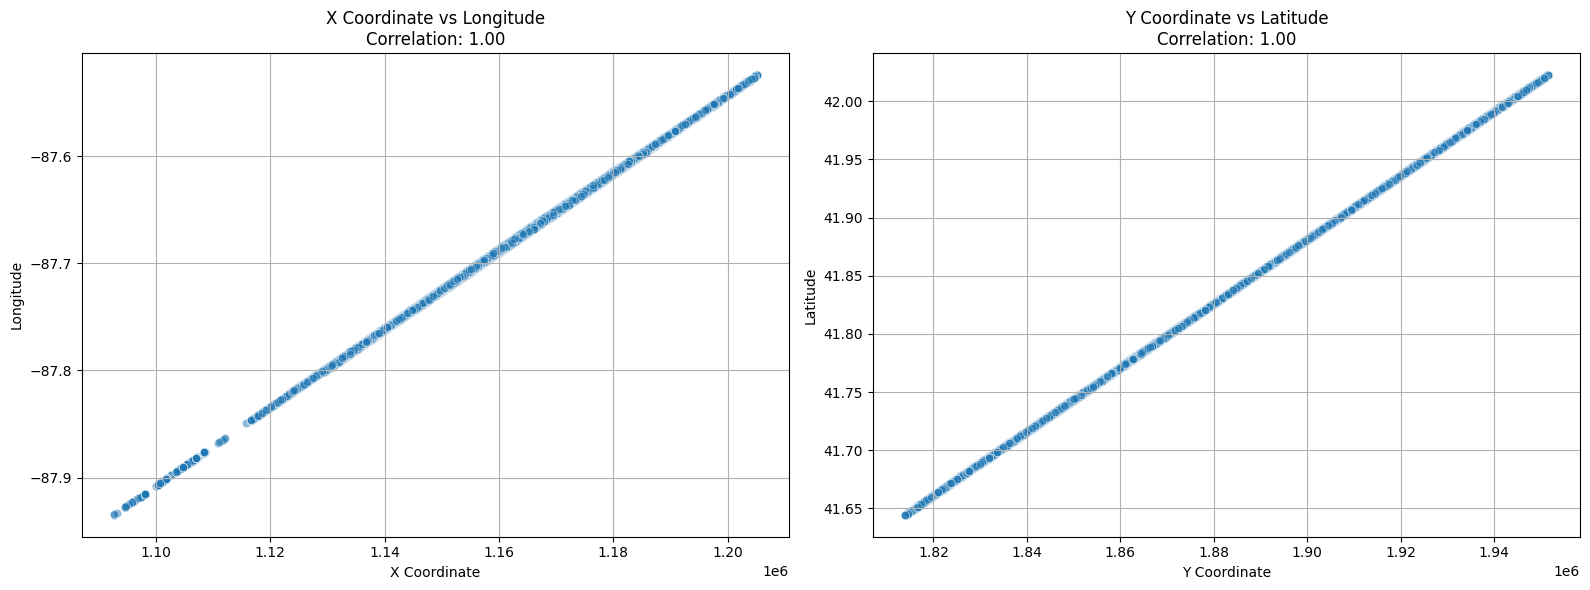

In [11]:
# Calculate correlations
correlation_long_x = df[['X Coordinate', 'Longitude']].corr().iloc[0, 1]
correlation_lat_y = df[['Y Coordinate', 'Latitude']].corr().iloc[0, 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Scatter plot for X Coordinate vs Longitude
sns.scatterplot(data=df, x='X Coordinate', y='Longitude', alpha=0.5, ax=axes[0])
axes[0].set_title(f"X Coordinate vs Longitude\nCorrelation: {correlation_long_x:.2f}")
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Longitude')
axes[0].grid(True)

# Scatter plot for Y Coordinate vs Latitude
sns.scatterplot(data=df, x='Y Coordinate', y='Latitude', alpha=0.5, ax=axes[1])
axes[1].set_title(f"Y Coordinate vs Latitude\nCorrelation: {correlation_lat_y:.2f}")
axes[1].set_xlabel('Y Coordinate')
axes[1].set_ylabel('Latitude')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

Eliminamos las columnas X Coordinate, Y Coordinate y dejamos las columnas Latitude, Longitude debido a que representan la misma informacion y pueden considerarse como datos duplicados.

In [12]:
df.drop(columns=['X Coordinate', 'Y Coordinate'], inplace=True)

Tenemos 1008 entradas faltantas para `Latitude` y `Longitude`, lo que representa solo un 0.4% del total de filas. Por lo tanto, eliminamos las filas con datos faltantes en estas columnas. Hacemos lo mismo con `Location Description` y `Community Area` ya que tienen un porcentaje de datos faltantes similar o menor.

>NOTA: `Latitude` y `Longitude` son variables que representan la ubicacion geografica del crimen, por eso se descarto la opcion de imputar los datos faltantes con tecnicas de imputacion ya que al hacer esto estariamos introduciendo ruido en los datos y afectando la calidad del modelo. Idem con `Location Description` ya que al ser una variable categorica de texto, es mejor eliminar las filas con datos faltantes (mas cuando la proporcion es tan pequenia) que imputar un valor que no tenga sentido. 

In [16]:
# Solo tengo nulos en las columnas mencionadas arriba, hacemos un drop sobre
# el dataframe para eliminar filas con faltantes.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256333 entries, 0 to 258377
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  256333 non-null  object 
 1   IUCR                  256333 non-null  object 
 2   Primary Type          256333 non-null  object 
 3   Description           256333 non-null  object 
 4   Location Description  256333 non-null  object 
 5   Arrest                256333 non-null  bool   
 6   Domestic              256333 non-null  bool   
 7   Beat                  256333 non-null  int64  
 8   District              256333 non-null  int64  
 9   Ward                  256333 non-null  int64  
 10  Community Area        256333 non-null  float64
 11  FBI Code              256333 non-null  object 
 12  Latitude              256333 non-null  float64
 13  Longitude             256333 non-null  float64
dtypes: bool(2), float64(3), int64(3), object(6)
memory usage:

### Normalizacion y creacion de nuevas caracteristicas

Las unicas columnas no categoricas que tenemos son `Latitude` y `Longitude`, las cuales representan coordenadas geograficas. Estas coordenadas varian entre -90 y 90 para `Latitude` y entre -180 y 180 para `Longitude` lo cual hace que se tenga que tener especial cuidado al momento de aplicar algoritmos basados en distancias ya que al ser coordenadas 2d que representan ubicaciones en una esfera, la distancia entre dos puntos no es lineal ni se puede tratar como si fuera un espacio euclidiano. Una transformacion util, que mapea las coordenadas a un espacio mas adecuado para el analisis, es la transformacion de las coordenadas a un sistema de coordenadas cartesianas. Esto se puede hacer utilizando la siguiente formula:

```
x = cos(Latitude) * cos(Longitude)
y = cos(Latitude) * sin(Longitude)
z = sin(Latitude)
```

Para aplicar esta transformacion, primero convertimos las coordenadas de grados a radianes y luego aplicamos la formula. Esto nos permite trabajar con las coordenadas de una manera mas adecuada para el analisis y evita problemas de distancias no lineales dejando los valores normalizados en un rango de -1 a 1 a los cuales si se les puede aplicar min-max scaling o z-score normalization.

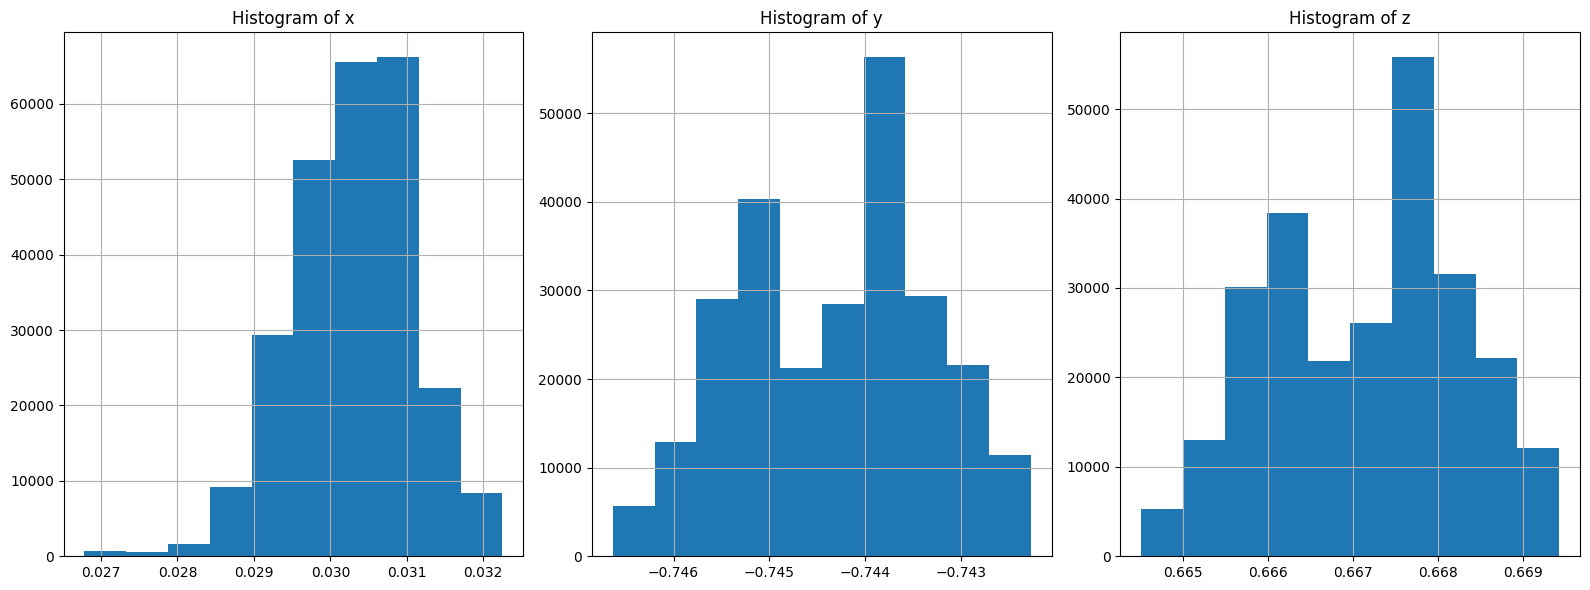

In [28]:
latitude_radians = np.radians(df['Latitude'])
longitude_radians = np.radians(df['Longitude'])

# Creamos 3 columnas nuevas con los nuevos datos geograficos
df['x'] = np.cos(latitude_radians) * np.cos(longitude_radians)
df['y'] = np.cos(latitude_radians) * np.sin(longitude_radians)
df['z'] = np.sin(latitude_radians)

plt.figure(figsize=(16, 6))
plt.subplot(131)
df['x'].hist()
plt.title('Histogram of x')
plt.subplot(132)
df['y'].hist()
plt.title('Histogram of y')
plt.subplot(133)
df['z'].hist()
plt.title('Histogram of z')
plt.tight_layout()


Con esta transformacion creamos nuevas features con una dimensionalidad mayor, pero que representan mejor la informacion geografica de los crimenes volviendo la informacion apta para ser utilizada en modelos de machine learning. La idea no es reemplazar las columnas originales `Latitude` y `Longitude`, sino complementarlas con estas nuevas features.
>NOTA: Esta transformacion no es estrictamente necesaria, pero puede mejorar el rendimiento de los modelos que utilizan distancias para hacer predicciones.

Normalizamos para llevar las variables al rango 0-1

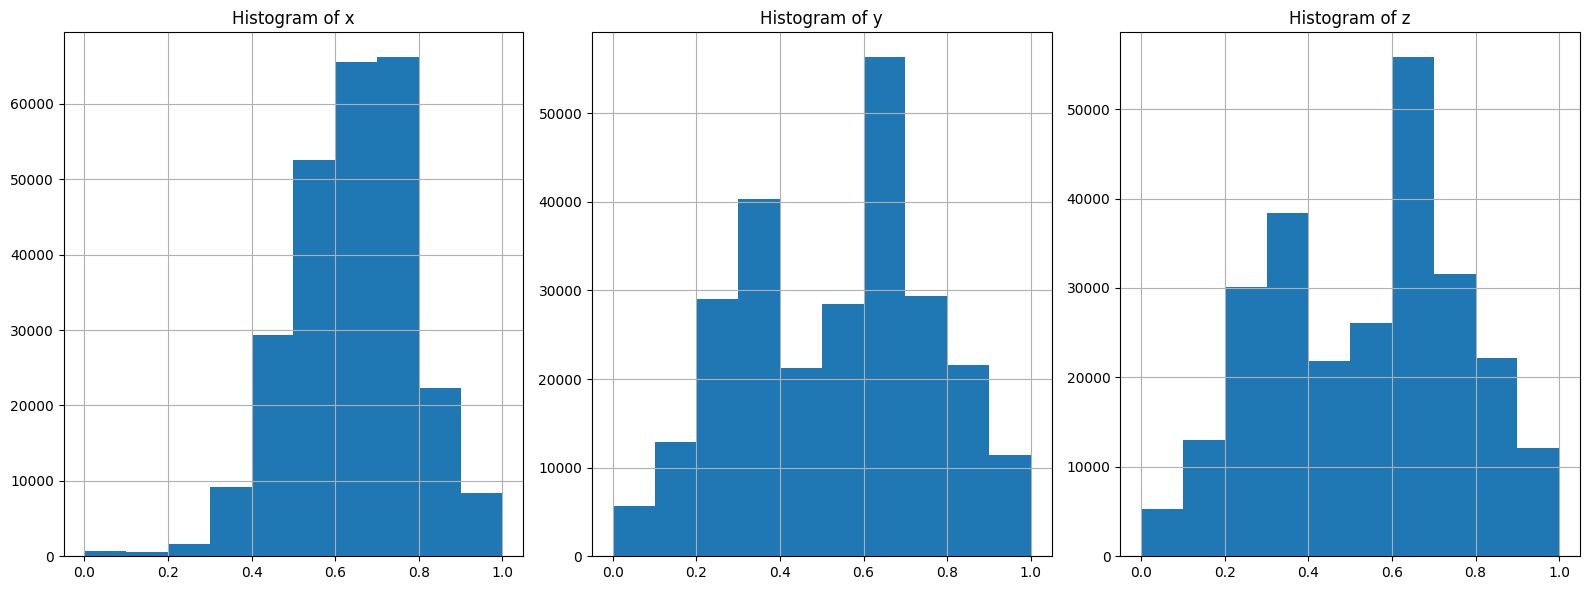

In [29]:
scaler = MinMaxScaler()
# Normalizamos las nuevas columnas
df[['x', 'y', 'z']] = scaler.fit_transform(df[['x', 'y', 'z']])

plt.figure(figsize=(16, 6))
plt.subplot(131)
df['x'].hist()
plt.title('Histogram of x')
plt.subplot(132)
df['y'].hist()
plt.title('Histogram of y')
plt.subplot(133)
df['z'].hist()
plt.title('Histogram of z')
plt.tight_layout()